In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
data = pd.read_csv('data.csv')
data.head()

,Date,btc,ltc,eth,time
0,2018/10/29 12:00,0.000000,0.009054,0.001974,310
1,2018/11/14 15:00,0.000000,0.000000,0.022685,697
2,2018/11/14 16:00,0.040175,0.058658,0.000000,698
3,2018/11/14 18:00,0.000000,0.000000,0.001335,700
4,2018/11/14 20:00,0.000000,0.006188,0.000000,702


In [4]:
ltc_threshold = data[data['ltc']>0][['time','ltc']]
ltc_threshold.head()

,time,ltc
0,310,0.009054
2,698,0.058658
4,702,0.006188
6,720,0.024334
7,810,0.005327


In [5]:
btc_threshold = data[data['btc']>0][['time','btc']]
btc_threshold.head()

,time,btc
2,698,0.040175
5,716,0.004979
6,720,0.010827
8,830,0.009715
9,834,0.030198


In [6]:
eth_threshold = data[data['eth']>0][['time','eth']]
eth_threshold.head()

,time,eth
0,310,0.001974
1,697,0.022685
3,700,0.001335
6,720,0.013042
7,810,0.001392


In [7]:
import scipy.stats as st
import statsmodels.api as sm

## 自激点过程
条件密度可以表示为：
$\tau(t)=\tau+\psi \int_{-\infty}^{t} c\left(\tilde{X}_{s}\right) g(t-s) d N(s), \quad \tau>0, \psi \geq 0$

其中，$c(\cdot)$为impact函数，$g(\cdot)$为decay函数。$c(x)=1+G^{\leftarrow}(F(x))=1-\frac{1}{\delta}\ln(1-\delta F(x))$,$F(x)=1-(1+\xi\frac{x-u}{\beta+\alpha v(t)})^{-1/\xi}$,$g1(t)=e^{-\gamma t}$,$g2(t)=\frac{1}{(t+\gamma)^{1+\rho}}$

In [8]:
def g(t,gamma):
    '''
    gamma:参数
    t:array数据类型
    '''
    return np.exp(-gamma*t)

定义$\tau$函数

In [ ]:
def tau(tau_0,t,psi,delta,gammma,df):
    return tau_0 + psi*V(t,delta,gamma,df)

# 画出$\tau$

In [172]:
def plot_tau(delta,gamma,series):
    start_time = np.min(series.index)
    time = np.arange(start_time,T,step=10)
    v = [V(t,delta,gamma,series) for t in time]
    plt.plot(time,v)
    plt.show()

In [195]:
def plot_g(gamma,series):
    start_time = np.min(series.index)
    time = np.arange(start_time,T,step=50)
    v = [V_sum(t,gamma,series) for t in time]
    plt.figure(figsize=(20,8))
    plt.plot(time,v)
    plt.show()

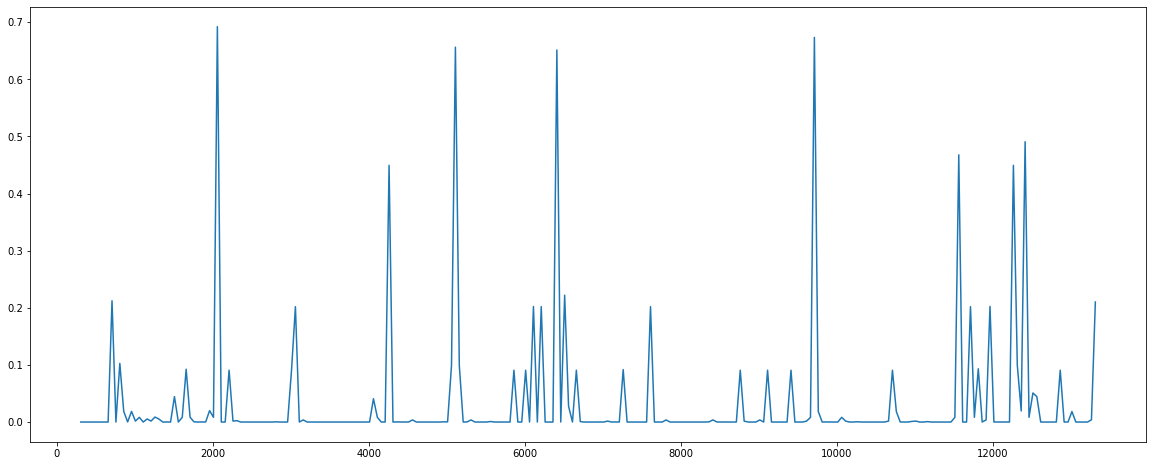

In [196]:
plot_g(0.8,eth_data)

## 似然函数如下所示：
$$
L=\exp \left(-\mathrm{T} \tau-\psi \int_{0}^{T} v(s) d s\right) \prod_{j=1}^{N} \lambda\left(T_{j}, \tilde{X}_{j}\right)
$$
其中，$\int_{0}^{T} v(s) d s=\int_{0}^{T} \sum_{j: 0<T_{j}<s} e^{-\gamma\left(s-T_{j}\right)} e^{\delta X_{T_j}}  d s$
$=\frac{1}{\gamma} \sum_{k=1}^{N}\left[\left(e^{-\gamma T_{k}}-e^{-\gamma T_{k+1}}\right) \sum_{j=1}^{k} e^{\gamma T_{j}} \times e^{\delta X_{T_j}} \right]$
而
$\lambda_{i}\left(t, x_{i}\right)=\frac{\tau_{i}+\psi_{i} v_{i}^{*}(t)}{\beta_{i}+\alpha_{i} v_{i}^{*}(t)}\left(1+\xi_{i} \frac{x_{i}}{\beta_{i}+\alpha_{i} v_{i}^{*}(t)}\right)^{-1 / \xi_{i}-1}$

下面先给出$\lambda$函数，在给出积分函数

In [9]:
def log_likelihood(tau0,psi,alpha,beta,xi,gamma,delta,T,df,col_name):
    n = len(df)
    max_t  = df['time'].max()
    df.index = np.arange(n)
    df['c'] = np.zeros(n)
    df['v'] = np.zeros(n)
    df['F'] = np.zeros(n)
    df['int_v'] = np.zeros(n)
    for i in range(n):
        df['F'][i] = 1-(1+xi*df[col_name][i]/(beta+alpha*df['v'][i]))**(-1/xi)
        df['c'][i] = 1-delta*np.log(1-df['F'][i])
        if i == 0:
            df['int_v'][i] = tau0 * df['time'][i]
        else:
            t1 = df['time'][i]-df['time'][i-1]
            t2 = (df['time'][i]-df['time'][:i]).apply(g,args=(gamma,))
            t3 = (df['time'][i-1]-df['time'][:i]).apply(g,args=(gamma,))
            sums = (df['c'][:i] * (t3-t2)).sum()
            df['int_v'][i] = tau0 * (t1) + psi / gamma * sums
        if i+1 != n:
            t = (df['time'][i+1]-df['time'][:i+1]).apply(g,args=(gamma,))
            df['v'][i+1] = (df['c'][:i+1]*t).sum()
    df['lambda'] = (tau0+psi*df['v'])/(beta+alpha*df['v'])*(1+xi*df[col_name]/(beta+alpha*df['v']))**(-1/xi-1)
    df['m'] = 1/xi*np.log(1+df[col_name]/(beta+alpha*df['v']))
    df_new = pd.DataFrame({'time':[T]})
    df = pd.concat([df,df_new],ignore_index=True)
    T1 = (df['time'].iloc[-1]-df['time'][:-1]).apply(g,args=(gamma,))
    T2 = (df['time'].iloc[-2]-df['time'][:-1]).apply(g,args=(gamma,))
    sums = (df['c'][:-1] * (T2-T1)).sum()
    df['int_v'].iloc[-1] = tau0 * (T-max_t) + psi / gamma * sums
    l = np.log(df['lambda']).sum()
    l = l-T*tau0-psi*df['int_v'].sum()/gamma
    return l,df

## 通过粒子群算法求解似然函数参数
模型的参数包括：$\tau$,$\psi$,$\alpha$,$\beta$,$\xi$,$\gamma$,$\delta$

下面为相应代码

In [12]:
def pso(nums,iteration,bound,T,df,col_name):
    """
    nums:初始化粒子位置，为m*n的Arrays,其中m为粒子个数，n为粒子特征数
    bound:参数的上下限
    T:
    df:数据
    """
    m,n = nums.shape # 初始化m个粒子，其中n为粒子位置维度
    #初始化速度
    v = np.random.randn(m,n)
    fitness = np.zeros(m)
    for i in range(m):
        fitness[i] = log_likelihood(nums[i,0],nums[i,1],nums[i,2],nums[i,3],nums[i,4],nums[i,5],nums[i,6],T,df,col_name)[0]
    c1 = c2 = 2
    p = nums
    pg = nums[np.argmax(fitness)]
    individual_best_fitness = fitness
    global_best_fitness = np.max(fitness)

    for step in range(iteration):
        r1 = np.random.rand(m, n)
        r2 = np.random.rand(m, n)
        # 更新速度和权重
        v = 0.6*v+c1*r1*(p-nums)+c2*r2*(pg-nums)
        nums = v + nums
        for i in range(m):
            for j in range(n):
                if nums[i,j] < bound[j][0]:
                    nums[i,j] = bound[j][0]
                elif nums[i,j] > bound[j][1]:
                    nums[i,j] = bound[j][1]
        for i in range(m):
            fitness[i] = log_likelihood(nums[i,0],nums[i,1],nums[i,2],nums[i,3],nums[i,4],nums[i,5],nums[i,6],T,df,col_name)[0]
        # 需要更新的个体
        update_id = np.less(individual_best_fitness, fitness)
        p[update_id] = nums[update_id]
        individual_best_fitness[update_id] = fitness[update_id]
        # 新一代出现了更小的fitness，所以更新全局最优fitness和位置
        if np.max(fitness) > global_best_fitness:
            pg = nums[np.argmax(fitness)]
            global_best_fitness = np.max(fitness)
    return nums

In [10]:
#likelihood(tau0,psi,alpha,beta,xi,gamma,delta,T,df)
m = 150
n = 7
bound = np.ones([n,2])*1
for i in range(7):
    bound[i][0] = 0.0001

In [11]:
bound

array([[1.e-04, 1.e+00],
       [1.e-04, 1.e+00],
       [1.e-04, 1.e+00],
       [1.e-04, 1.e+00],
       [1.e-04, 1.e+00],
       [1.e-04, 1.e+00],
       [1.e-04, 1.e+00]])

In [12]:
nums = 0.9999 * np.random.rand(m,n) + 0.0001
nums

array([[0.95885389, 0.87020721, 0.38313938, ..., 0.15029677, 0.05504265,
        0.73383156],
       [0.17934287, 0.11124178, 0.81719441, ..., 0.65189516, 0.17896307,
        0.49158444],
       [0.45330151, 0.48323493, 0.75592722, ..., 0.70983875, 0.88789177,
        0.37564109],
       ...,
       [0.70354665, 0.39600766, 0.2456147 , ..., 0.18462615, 0.08114999,
        0.47521896],
       [0.79559581, 0.19476568, 0.73123155, ..., 0.28600008, 0.03840829,
        0.6047891 ],
       [0.23092529, 0.22938727, 0.98457415, ..., 0.77213521, 0.55928206,
        0.60068493]])

In [13]:
T = 13350
T

13350

In [14]:
t1 = datetime.now()
fitness = np.zeros(m)
for i in range(m):
    fitness[i] = log_likelihood(tau0=nums[i,0],psi=nums[i,1],alpha=nums[i,2],beta=nums[i,3],xi=nums[i,4],gamma=nums[i,5],delta=nums[i,6],
                                T=T,df=eth_threshold,col_name='eth')[0]
t2 = datetime.now()
print(t2-t1)

0:01:20.303766


In [18]:
import warnings
warnings.filterwarnings("ignore")
results = pso(nums,iteration=500,bound=bound,T=T,df=eth_threshold,col_name='eth')

In [19]:
fitness = np.zeros(m)
for i in range(m):
    fitness[i] = log_likelihood(results[i,0],results[i,1],results[i,2],results[i,3],results[i,4],results[i,5],results[i,6],T,eth_threshold,'eth')[0]

In [20]:
pg = results[np.argmax(fitness)]

In [21]:
pg

array([1.00000000e-04, 5.66637936e-01, 5.31988134e-01, 2.52864262e-02,
       2.56091351e-01, 6.66704897e-01, 6.99029423e-01])

In [22]:
fitness.max()

-609.6795921241558

In [24]:
df = log_likelihood(pg[0],pg[1],pg[2],pg[3],pg[4],pg[5],pg[6],T,eth_threshold,'eth')[1]

In [30]:
df

,time,eth,c,v,F,lambda,g,rg,g_diff,sum1,sum2,m
0,310,0.001974,1.054025,0.000000e+00,0.074374,0.003589,1.740444e-90,5.745661e+89,1.740444e-90,6.056068e+89,1.054025,0.293484
1,697,0.022685,1.564504,9.299272e-113,0.554053,0.001434,1.535530e-202,6.512411e+201,1.327742e-202,1.018870e+202,1.352796,2.500436
2,700,0.001335,1.006758,2.117084e-01,0.009621,0.860057,2.077875e-203,4.812609e+202,2.077872e-203,5.864003e+202,1.218465,0.037617
3,720,0.013042,1.338627,1.971916e-06,0.383948,0.002176,3.362747e-209,2.973759e+208,3.362747e-209,3.980759e+208,1.338629,1.624081
4,810,0.001392,1.038205,1.168145e-26,0.053188,0.003692,2.934479e-235,3.407760e+234,2.934479e-235,3.537953e+234,1.038205,0.209212
...,...,...,...,...,...,...,...,...,...,...,...,...
130,12938,0.001258,1.034567,5.364414e-36,0.048247,0.003717,0.000000e+00,inf,0.000000e+00,inf,NaN,0.189641
131,13062,0.002910,1.079282,1.291286e-36,0.107222,0.003430,0.000000e+00,inf,0.000000e+00,inf,NaN,0.425342
132,13211,0.000536,1.014767,7.775752e-44,0.020904,0.003851,0.000000e+00,inf,0.000000e+00,inf,NaN,0.081852
133,13249,0.008998,1.238050,1.008344e-11,0.288617,0.002578,0.000000e+00,inf,0.000000e+00,inf,NaN,1.188707


In [108]:
np.save('nums',results)

## residual inter-exceedance intervals
$\chi_j=\int_{T_j}^{T_{j+1}}\tau(s,u)ds=\tau_0(T_{j+1}-T_{j})+\frac{\psi}{\gamma}\sum_{i=1}^{j}c(x_{T_i})e^{\gamma T_i}(e^{-\gamma T_j}-e^{-\gamma T_{j+1}})$

In [4]:
def interval(tau0,psi,gamma,delta,df):
    return df['sum2'] * psi / gamma + tau0 * (df['time'].shift(-1)-df['time'])

## residual marks
$m_j=-\frac{1}{\xi}\log(1+\frac{X_{T_j}-u}{\beta+\alpha v(T_j)})$

In [23]:
def mark(xi,beta,alpha,df,col_name):
    df['m'] = np.log(1+df[col_name]/(beta+alpha*df['v']))/xi
    return df['m'].values

In [26]:
ma = mark(xi=pg[4],beta=pg[3],alpha=pg[2],df=df,col_name='eth')

In [27]:
ma

array([2.93483860e-01, 2.50043581e+00, 3.76168397e-02, 1.62408069e+00,
       2.09211593e-01, 2.85387221e+00, 1.91172387e+00, 3.12840364e-01,
       2.40032769e-01, 1.69384435e+00, 1.19127286e+00, 1.00292346e-01,
       3.56101288e+00, 2.49133319e-01, 4.02623600e-02, 1.95084430e-01,
       1.06300437e-01, 3.76902894e-01, 1.45326270e+00, 1.28918488e+00,
       1.05446983e+00, 4.17262783e-02, 2.82700868e+00, 7.65044515e-01,
       7.09760287e-01, 7.66598699e-01, 2.38194087e-01, 3.68001016e+00,
       5.18626150e-01, 2.94817678e+00, 4.41527306e-01, 1.53955897e+00,
       1.69972928e-02, 2.17203951e+00, 3.49809544e+00, 1.14092993e-03,
       4.60405690e+00, 9.57715837e-02, 1.35700518e+00, 3.50569178e+00,
       2.93713085e+00, 1.43925646e-01, 6.78975178e-01, 6.37557323e+00,
       1.59223847e+00, 1.81377047e+00, 9.86729935e-01, 1.49780970e+00,
       2.18804402e+00, 1.91952591e-01, 2.24280533e-01, 1.77402235e-01,
       1.41287912e-01, 2.06671502e-01, 5.64057823e-01, 9.11694580e-01,
      

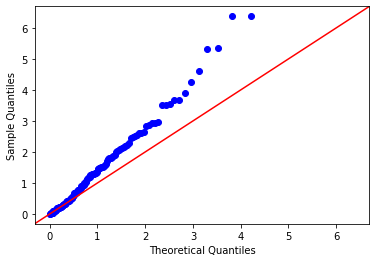

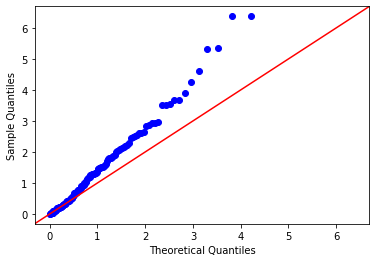

In [31]:
probplot_mark = sm.ProbPlot(ma,dist=st.expon,scale=1)
probplot_mark.qqplot(line='45')

## Ljung–Box test

## Kolmogorov–Smirnov test

In [9]:
rvs1 = st.norm.rvs(loc=5,scale=10,size=500)
rvs2 = st.norm.rvs(loc=5,scale=10,size=500)
st.ks_2samp(rvs1,rvs2)

Ks_2sampResult(statistic=0.048, pvalue=0.6126241113875229)

In [10]:
st.ttest_ind(rvs1,rvs2)

Ttest_indResult(statistic=-0.9126842476239643, pvalue=0.3616290489426698)